Feature Engineering and Model Training

Going to make use a recurrent neurel network called LSTM (Long short term memory) for modelling stock price data as the data is sequential. As stock price data is sequential, where each data point depends on the previous ones. RNNs are designed to capture temporal dependencies, making them well-suited for modeling and predicting time series data.

Going to use the stock market prediction using LSTM recurrent neural network paper by Adil Moghar and Mhamed Hamiche as reference (https://www.sciencedirect.com/science/article/pii/S1877050920304865) to make my own model.

In [588]:
# Data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from datetime import datetime

# Data processing
from sklearn.preprocessing import MinMaxScaler

# Model and measure metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Going to create a model for the google stock price dataset

In [589]:
traindf = pd.read_csv('../datasets/GOOG.csv')

testdf = pd.read_csv('../datasets/GOOG_Test.csv')

In [590]:
traindf.Date = pd.to_datetime(traindf['Date'])
traindf = traindf.set_index('Date')

testdf.Date = pd.to_datetime(testdf['Date'])
testdf = testdf.set_index('Date')

In [591]:
traindf = traindf.drop(['Close'], axis='columns')
traindf = traindf.rename(columns={'Adj Close': 'Close'})

In [592]:
train_dates = traindf.index
test_dates = testdf.index

In [593]:
train = np.array(traindf.Close)
test = np.array(testdf.Close)

train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [594]:
sc = MinMaxScaler(feature_range=(0,1))
train = sc.fit_transform(train)
test = sc.transform(test)

In [595]:
len(train), len(test)

(1510, 251)

Need to convert the data into supervised format for neural network. So data needs to be in (x,y) format where x are the features and y is the target. As time series data is sequential the features x are the number of previous days prices we use to predict next days price.

Going to use past 32 days as features as look back so, x(t-32), x(t-31), ... , x(t-1) will give x(t) which is y(t) 

In [596]:
look_back = 32

In [597]:
def preprocess_data(dataset,step):
    X = []
    Y = []
    for i in range(step, len(dataset)):
        X.append(dataset[i-step:i, 0])
        Y.append(dataset[i, 0])
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

In [598]:
X_train, y_train = preprocess_data(train,look_back)
X_test, y_test = preprocess_data(test, look_back)

In [599]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
impl = model.fit(
    X_train,
    y_train,
    validation_split=0.33,
    epochs=100,
    batch_size=60
    )

Epoch 1/100
17/17 [==============================] - 5s 130ms/step - loss: 0.0076 - val_loss: 0.0263
Epoch 2/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 3/100
17/17 [==============================] - 1s 71ms/step - loss: 9.9122e-04 - val_loss: 0.0049
Epoch 4/100
17/17 [==============================] - 1s 78ms/step - loss: 9.1358e-04 - val_loss: 0.0041
Epoch 5/100
17/17 [==============================] - 1s 83ms/step - loss: 8.5218e-04 - val_loss: 0.0033
Epoch 6/100
17/17 [==============================] - 2s 104ms/step - loss: 8.4461e-04 - val_loss: 0.0044
Epoch 7/100
17/17 [==============================] - 1s 68ms/step - loss: 8.6489e-04 - val_loss: 0.0036
Epoch 8/100
17/17 [==============================] - 1s 68ms/step - loss: 8.0972e-04 - val_loss: 0.0040
Epoch 9/100
17/17 [==============================] - 1s 69ms/step - loss: 7.9634e-04 - val_loss: 0.0050
Epoch 10/100
17/17 [==============================] - 1s 68ms/step - l

In [600]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_124 (LSTM)             (None, 32, 100)           40800     
                                                                 
 dropout_112 (Dropout)       (None, 32, 100)           0         
                                                                 
 lstm_125 (LSTM)             (None, 32, 100)           80400     
                                                                 
 dropout_113 (Dropout)       (None, 32, 100)           0         
                                                                 
 lstm_126 (LSTM)             (None, 32, 100)           80400     
                                                                 
 dropout_114 (Dropout)       (None, 32, 100)           0         
                                                                 
 lstm_127 (LSTM)             (None, 100)             

Plot the training and validation loss to make sure overfitting does not occur and data is only trained on general principles.

Can see validation loss never trends up, so model is never trained too close to the training set.

In [601]:
impl.history.keys()

dict_keys(['loss', 'val_loss'])

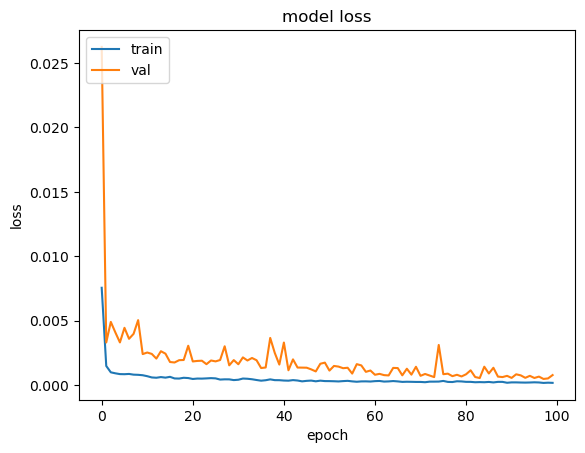

In [602]:
plt.plot(impl.history['loss'])
plt.plot(impl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [603]:
np.array(train[len(train)-look_back:]).shape

(32, 1)

In [604]:
np.array(test).shape

(251, 1)

In [605]:
predictions = model.predict(X_test)
predictions = sc.inverse_transform(predictions)
test = sc.inverse_transform(test)
train = sc.inverse_transform(train)
train = pd.DataFrame(train, index=train_dates)
test = pd.DataFrame(test, index=test_dates)
predictions = pd.DataFrame(predictions, index=test_dates[look_back:])

rmse = np.sqrt(np.mean(((predictions - test[look_back:]) ** 2)))
rmse


7/7 [==============================] - 1s 14ms/step


2.799549132576488

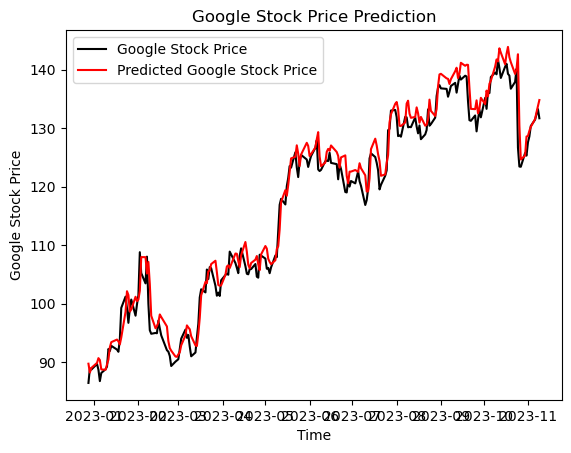

In [606]:
figure, axes = plt.subplots( 1 ) 

axes.plot(test[look_back:], color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()

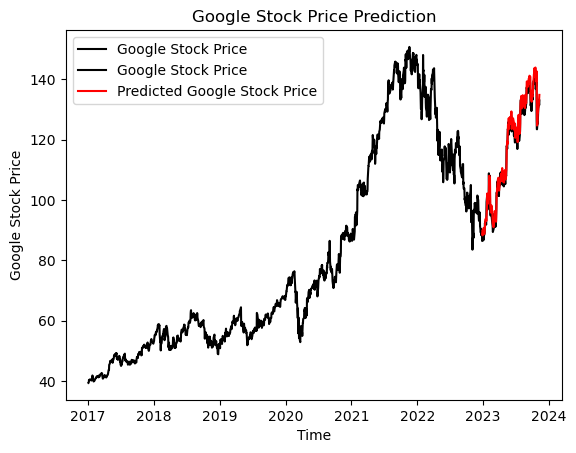

In [607]:
figure, axes = plt.subplots( 1 ) 

axes.plot(train, color = 'black', label = 'Google Stock Price')
axes.plot(test[look_back:], color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()